In [1]:
device = 'cuda'

# TODO:
# Conditional fig saving
# m1p-path to vairable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tqdm import tqdm
from typing import Dict

import torch
import torch.nn as nn
import torch.fx

from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')

# TODO:
# add the files to repository and clone it instead of importing it from drive
import sys
sys.path.append('/content/drive/MyDrive/m1p')

from fast_nas_adapt.src.resnet18 import ResNet18
from fast_nas_adapt.src.module2graph import GraphInterperterWithGamma


<ipython-input-3-df359bd009d5>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [4]:
class GraphInterperterWithGumbelSoftmaxGamma(GraphInterperterWithGamma):
    def __init__(self, mod, gamma_shift=0.0, temperature=1.0):
        self.gamma_shift = gamma_shift
        self.temperature = temperature
        super().__init__(mod)

    def init_gammas(self):
        i = 0
        gammas = []
        self.gammas_name = {}
        self.atomic_operations = []
        for node in self.graph.nodes:
            if node.op == 'call_module':
                self.atomic_operations.append(node)
                gammas.append(np.random.randn()+self.gamma_shift)
                self.gammas_name[str(node)] = i# перевод в str тут для удобства. в реалньых методах это не нужно
                i+=1                        # да и вообще, тут по идее должен быть тензор/параметр
        self.gammas = torch.as_tensor(gammas).to(device)
        self.discrete = False 

    def sample_gammas(self, previous=False):
        if self.discrete:
            return self.gammas

        if not previous:
            d = torch.distributions.RelaxedBernoulli(logits=self.gammas, temperature=self.temperature)
            self.last_sample = d.rsample()

        return self.last_sample
        
    def make_gammas_discrete(self):
        self.gammas.data = (self.gammas.data>=0) * 1.0
        self.discrete = True

    def get_atomic_operations(self):
        return self.atomic_operations

In [5]:
class HyperNet(nn.Module):
    def __init__(self, out_size, hidden_layer_num=1, hidden_size=128):
        """
        :param hidden_layer_num: количество скрытых слоев (может быть нулевым)
        :param hidden_size: количество нейронов на скрытом слое (актуально, если скрытые слои есть)
        :param out_size: количество параметров
        """
        nn.Module.__init__(self)

        layers = []
        in_ = 1 # исходная входная размерность
        for _ in range(hidden_layer_num):
            layers.append(nn.Linear(in_, hidden_size))
            layers.append(nn.ReLU())
            in_ = hidden_size
        layers.append(nn.Linear(in_, out_size))

        self.model = nn.Sequential(*layers)

    def forward(self, lambd):
        return self.model(lambd)

Получим претрейн на n эпох

In [6]:
model = ResNet18(num_classes=10).cuda()

model_path = '/content/drive/MyDrive/m1p/pretrained/model_23.ckpt'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [7]:
from fast_nas_adapt.src.cifar_data import get_dataloaders

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64,
                                    img_size=33)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
times_path = "/content/drive/MyDrive/m1p/ResNet18HomeMeasurments.csv"
times = pd.read_csv(times_path, index_col=0)
times = torch.tensor(times['mean'], dtype=torch.float32).to(device)
times /= times.sum()

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()

@torch.no_grad()
def validate(model, dataloader, device, get_accuracy=True, get_loss=True, get_time=True):
    n_true, n_tot = 0, 0
    loss, time = 0, 0

    for i, (X, y) in enumerate(dataloader):
        if X.shape[0] != 64:
            continue
        y_pred = model(X.to(device))

        n_tot += 64

        if get_accuracy:
            n_true += (y_pred.argmax(-1) == y.to(device)).sum().item()
        if get_loss:
            loss += loss_fn(y_pred, y.to(device)).item() * 64
        if get_time:
            time += model.sample_gammas(previous=True).to(device).dot(times).item() * 64
    return n_true / n_tot, loss / n_tot, time / n_tot

@torch.no_grad()
def get_imodel(init_gammas=None, *, discrete: bool, temperature: float=1, device=device):
    result = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), temperature=temperature).to(device).eval()
    if init_gammas is not None:
        result.gammas = init_gammas
    if discrete:
        result.make_gammas_discrete()
    return result

In [10]:
getters = {'get_accuracy': True, 'get_loss': True, 'get_time': False}
base_accuracy, base_loss, _ = validate(model, test_dl, device, **getters)
base_accuracy, base_loss

(0.6464342948717948, 1.3685274429810352)

In [11]:
getters = {'get_accuracy': True, 'get_loss': True, 'get_time': False}
imodel = get_imodel(discrete=False)
worst_accuracy, worst_loss, _ = validate(imodel, test_dl, device, **getters)
worst_accuracy, worst_loss

(0.09975961538461539, 2.3264930171844287)

In [12]:
Lambd = worst_loss - base_loss
Lambd

0.9579655742033935

In [81]:
class DegenerateUniform:
  def __init__(self, value):
    self.value = torch.tensor([float(value)])

  def sample(self):
    return self.value

In [149]:
target_sampler = Normal(torch.tensor([5.]*60), torch.tensor([1.]*60))
lambda_sampler = Uniform(0, Lambd)
# lambda_sampler = DegenerateUniform(1)


def pretrain_epoch(hypernet, optimizer, *,
                   repeat=1,
                   lambda_sampler=lambda_sampler,
                   target_sampler=target_sampler):
    for i in range(repeat):
        lambd = lambda_sampler.sample().to(device).view(1)

        optimizer.zero_grad()

        gammas = hypernet(lambd)
        loss = torch.linalg.norm(gammas - target_sampler.sample().to(device), 1)/30 + lambd * gammas.dot(times)
        loss.backward()

        optimizer.step()


def train_epoch(hypernet, optimizer, lambda_sampler=lambda_sampler, dl=train_dl, temperature=1):
    for i, (X, y) in enumerate(dl):
        if X.shape[0] != 64:
            continue

        lambd = lambda_sampler.sample().to(device).view(1)

        optimizer.zero_grad()

        gammas = hypernet(lambd)
        imodel = get_imodel(gammas, discrete=False, temperature=temperature)
        y_pred = imodel(X.to(device))
        loss = loss_fn(y_pred, y.to(device)) + lambd * imodel.sample_gammas(previous=True).dot(times)
        loss.backward()

        optimizer.step()

Гиперпараметры:

In [150]:
params_count = len(imodel.gammas)
hypernet = HyperNet(params_count, hidden_layer_num=2).to(device)

optimizer = torch.optim.Adam(hypernet.parameters())

Предобучим гиперсеть, чтобы для основного обучения она опиралась на связную модель

In [151]:
lambd = torch.tensor([0.]).to(device)

gammas_history = []
gammas_history.append(hypernet(lambd).detach().cpu())

current_accuracy = worst_accuracy

while current_accuracy <= 0.2:
    pretrain_epoch(hypernet, optimizer, repeat=5)

    gammas = hypernet(lambd)
    imodel = get_imodel(gammas, discrete=False)
    getters = {'get_accuracy': True, 'get_loss': False, 'get_time': False}
    current_accuracy, _, _ = validate(imodel, test_dl, device, **getters)
    print(current_accuracy)

    gammas = hypernet(lambd).detach().cpu()
    gammas_history.append(gammas)

0.09945913461538461
0.10226362179487179
0.1015625
0.09905849358974358
0.09825721153846154
0.1038661858974359
0.11548477564102565
0.16927083333333334
0.26061698717948717


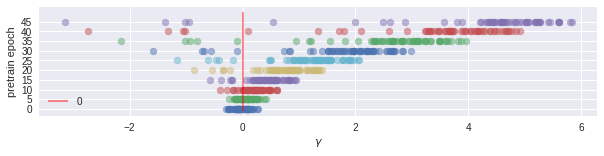

In [152]:
plt.figure(figsize=(10, len(gammas_history)/5))

for i, gammas in enumerate(gammas_history):
    plt.scatter(gammas, gammas*0 + 5*i, alpha=0.5);

plt.vlines(0, -1, len(gammas_history)*5, color='red', label='0', alpha=0.5)

plt.yticks(list(range(0, len(gammas_history)*5, 5)))

plt.xlabel('$\gamma$')
plt.ylabel('pretrain epoch')

plt.legend();

Обучем гиперсеть, понижая температуру.

In [169]:
EPOCHS = 1*5

temperature = 2

torch.save(hypernet.state_dict(), './temp')
hypernet_states = [torch.load('./temp')]
hypernet.train()

for epoch in tqdm(range(EPOCHS), desc='training', total=EPOCHS):
    train_epoch(hypernet, optimizer, temperature=temperature)
    temperature *= 0.9
    
    # save-load to detach
    torch.save(hypernet.state_dict(), './temp')
    hypernet_states.append(torch.load('./temp'))

hypernet.eval();

training: 100%|██████████| 5/5 [02:26<00:00, 29.37s/it]


Соберём статистики для визуализации.

In [170]:
lambds = [0., .1, .2, .5, 1., ]

# TODO
# replace list of dicts with dict of lists
accuracy_history = []
loss_history = []
time_history = []
gamma_history = []

for epoch, hypernet_state in tqdm(enumerate(hypernet_states),
                                  desc='validating history',
                                  total=len(hypernet_states)):
    accuracy_history.append({})
    loss_history.append({})
    time_history.append({})
    gamma_history.append({})

    hypernet.load_state_dict(hypernet_state)

    for lambd in lambds:
        gammas = hypernet(torch.tensor([lambd]).to(device))

        imodel = get_imodel(gammas, discrete=False)

        accuracy, loss, time = validate(imodel, test_dl, device)
        accuracy_history[-1][(lambd, False)] = accuracy
        loss_history[-1][(lambd, False)] = loss + lambd * time
        time_history[-1][(lambd, False)] = time
        gamma_history[-1][(lambd, False)] = imodel.sample_gammas()

        imodel.make_gammas_discrete()

        accuracy, loss, time = validate(imodel, test_dl, device)
        accuracy_history[-1][(lambd, True)] = accuracy
        loss_history[-1][(lambd, True)] = loss + lambd * time
        time_history[-1][(lambd, True)] = time
        gamma_history[-1][(lambd, True)] = imodel.sample_gammas()

validating history: 100%|██████████| 26/26 [08:02<00:00, 18.57s/it]


Изобразим исторические кривые.

In [171]:
dir = '/'
dir = '/last/'

lambd_colors = {
    0.:  'green',
    .1:  'yellow',
    .2:  'orange',
    .5:  'red',
    1.: 'black',
}


def plot_history(history, *, base=None, worst=None, ylabel, save_suffix,
                 lambds=lambds, colors=lambd_colors):
  
    plt.figure(figsize=(10,5))

    if base is not None:
        plt.plot([0, len(history)-1], [base]*2, ls=':', label="base")
    if worst is not None:
        plt.plot([0, len(history)-1], [worst]*2, ls=':', label="worst")

    for lambd in lambds:
        soft, discrete = [], []

        plt.plot([entry[(lambd, False)] for entry in history],
                 label=f"$\lambda={lambd}$ relaxed", c=colors[lambd], ls='--')
        
        plt.plot([entry[(lambd, True)] for entry in history],
                 label=f"$\lambda={lambd}$ discrete", c=colors[lambd])

    plt.ylabel(ylabel)
    plt.xlabel('Эпоха')

    plt.legend()
    plt.savefig(f'/content/drive/MyDrive/m1p/figs{dir}{save_suffix}.png', bbox_inches='tight')

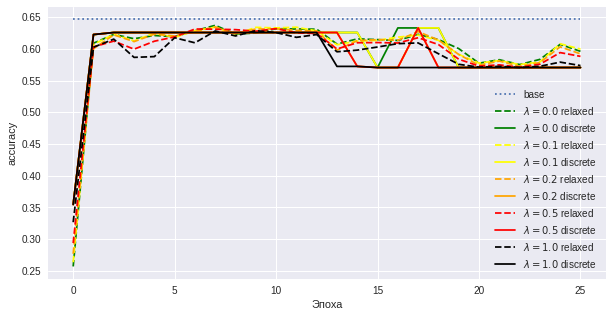

In [172]:
plot_history(accuracy_history, base=base_accuracy,
             ylabel='accuracy', save_suffix='accuracy_history')

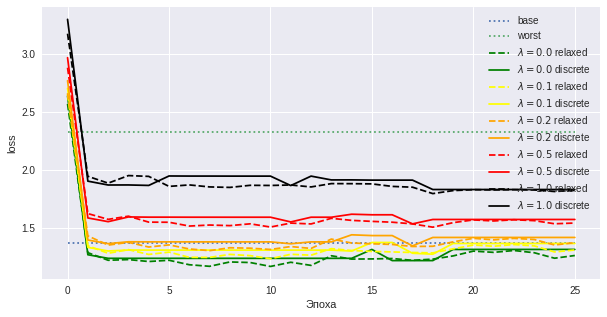

In [173]:
plot_history(loss_history, base=base_loss, worst=worst_loss,
             ylabel='loss', save_suffix='loss_history')

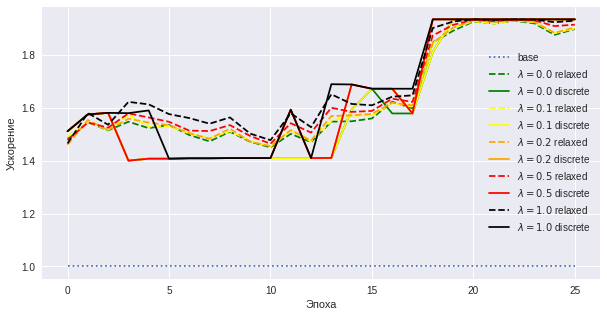

In [174]:
accel_history = [{k: 1/(t+1e-10) for k, t in d.items()} for d in time_history]

plot_history(accel_history, base=1,
             ylabel='Ускорение', save_suffix='accel_history')
# plt.ylim(0, 2);

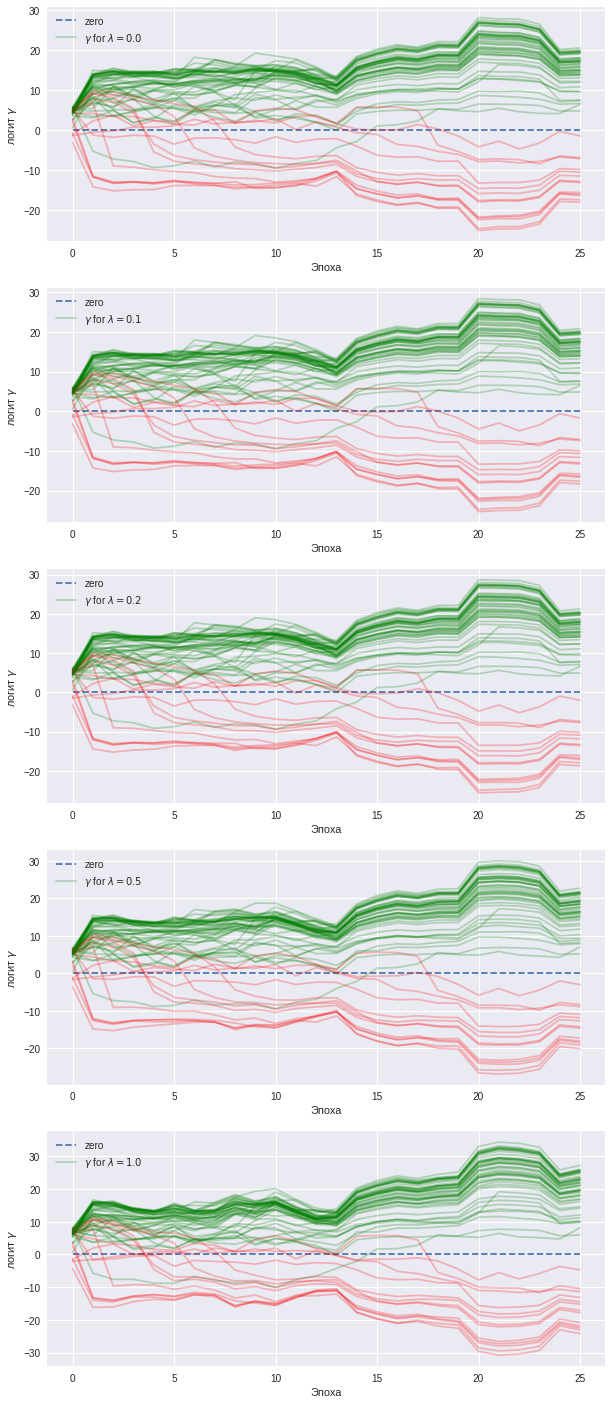

In [175]:
plt.figure(figsize=(10,25))
for subplot, lambd in enumerate(lambds, 1):
    plt.subplot(5, 1, subplot)

    plt.plot([0, epoch], [0, 0], ls='--', label="zero")

    pos_label, neg_label = False, False

    for i in range(60):
        gamma_history = []

        for hypernet_state in hypernet_states:
            hypernet.load_state_dict(hypernet_state)
            gamma = hypernet(torch.tensor([lambd]).to(device))[i].item()
            gamma_history.append(gamma)

        color = 'green' if gamma >= 0. else 'red'


        if i == 0:
          plt.plot(list(range(0, len(hypernet_states))), gamma_history,
                  color=color, alpha=0.25, label=f'$\gamma$ for $\lambda = {lambd}$')
        else:
          plt.plot(list(range(0, len(hypernet_states))), gamma_history,
                  color=color, alpha=0.25)

    plt.ylabel('логит $\gamma$')
    plt.xlabel('Эпоха')

    plt.legend()
    plt.savefig(f'/content/drive/MyDrive/m1p/figs{dir}gammas_logits_hypernet.png', bbox_inches='tight')

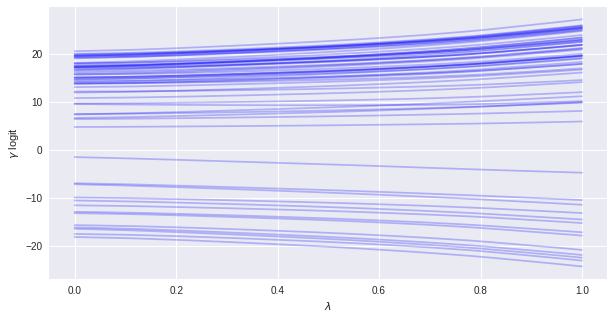

In [176]:
hypernet.load_state_dict(hypernet_states[-1])

lambd_grid = torch.tensor(np.linspace(0, 1, 101), dtype=torch.float32).to(device).view(-1, 1)
gammas_vs_lambda = hypernet(lambd_grid)

plt.figure(figsize=(10,5))

plt.plot(lambd_grid.cpu(), gammas_vs_lambda.detach().cpu(), alpha=0.25, color='blue')

plt.xlabel("$\lambda$")
plt.ylabel("$\gamma$ logit");